In [1]:
import numpy as np
import pystan
import arviz
import time
import pickle

total_start = time.time()

In [83]:
K = 5
MAXSKILLS = 4

chains = 4
warmup = 500
iters = 2500 + warmup

with open('Y.npy', 'rb') as f:
    obsY = np.load(f).astype(int)
    
with open('idxY.npy', 'rb') as f:
    idxY = np.load(f).astype(int)
    
with open('T.npy', 'rb') as f:
    T = np.load(f)

I = T.shape[0]
T = np.array(T.tolist())
max_T = max(T)

obsData = (np.ones((I, max_T, K))).astype(int)
for i in range(I):
    for t in range(max_T):
        for s in range(MAXSKILLS):
            idx = int(idxY[i][t][s]) - 1
            if idx >= K:
                continue
            obsData[i][t][idx] = 1
obsData = obsData.astype(int)

num_observations = sum(T)

In [84]:
stan_model = """
data {
    int I;                          // Num. students
    int K;                          // Num. skills
    int max_T;                      // largest number in T
    int T[I];                       // #opportunities for each of the I students
    int MAXSKILLS;
    int idxY[I,max_T,MAXSKILLS];
    int y[I,max_T,MAXSKILLS];       // output
}
parameters {
    vector[I] theta;
    vector<lower = 0, upper = 2.5>[K] lambda0;
    vector[K] lambda1;
    vector<lower = 0, upper = 1>[K] learn;
    vector<lower = 0, upper = 0.5>[K] g;
    vector<lower = 0.5, upper = 1>[K] ss;
}
model {
    
    real lp[I, max_T, K];
    real bern_G[I,max_T,K];
    real bern_S[I,max_T,K];
    real value[I,K];
    
    theta ~ normal(0, 1);
    lambda0 ~ uniform(0.0, 2.5);
    lambda1 ~ normal(0, 1);
    learn ~ beta(1, 1);
    ss ~ uniform(0.5, 1.0);
    g ~ uniform(0.0, 0.5);
 
    for (i in 1:I){
        for (k in 1:K){
            value[i,k] = inv_logit(1.7 * lambda1[k] * (theta[i] - lambda0[k]) );
         }
     } 
     
    for (i in 1:I) {
        for (t in 1:T[i]){
            for (s in 1:MAXSKILLS){
                if (idxY[i,t,s] <= K && y[i,t,s] != -1){
                    bern_G[i,t,idxY[i,t,s]] = pow(g[idxY[i,t,s]], y[i,t,s]) * pow(1-g[idxY[i,t,s]], 1-y[i,t,s]);
                    bern_S[i,t,idxY[i,t,s]] = pow(ss[idxY[i,t,s]], y[i,t,s]) * pow(1-ss[idxY[i,t,s]], 1-y[i,t,s]);
                }
            }
        }
     }
     
    for (i in 1:I){
        for (s in 1:MAXSKILLS) {
            if (idxY[i,1,s] <= K) {
                lp[i,1,idxY[i,1,s]] = bern_G[i,1,idxY[i,1,s]] + (value[i,idxY[i,1,s]] * (bern_S[i,1,idxY[i,1,s]] - bern_G[i,1,idxY[i,1,s]]));
                target += log(lp[i,1,idxY[i,1,s]]);
            }
        }
    }
    
    for (i in 1:I){
        for (t in 2:T[i]) {
            for (s in 1:MAXSKILLS){
                if (idxY[i,t,s] <= K){
                    lp[i,t,idxY[i,t,s]] = bern_S[i,t,idxY[i,t,s]] + ((bern_G[i,t,idxY[i,t,s]] - bern_S[i,t,idxY[i,t,s]]) * (1-value[i,idxY[i,t,s]]) * pow(1-learn[idxY[i,t,s]], t) );
                    target += log(lp[i,t,idxY[i,t,s]]);
                }
            }
        }
    }
}
generated quantities {}
"""


In [85]:
print("compiling stan model..")
start = time.time()
hotDINA = pystan.model.StanModel(model_code=stan_model, model_name="hotDINA")
compile_time = time.time() - start
print("Stan model took", compile_time, "s to compile")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL hotDINA_0169052b413d03a229c34988eca0dc2d NOW.


compiling stan model..
Stan model took 101.64097595214844 s to compile


In [86]:
fitting_start_time = time.time()



hotDINA_fit = hotDINA.sampling(data={'I': I,
                                     'K': K,
                                     'max_T': max_T,
                                     'T': T,
                                     'MAXSKILLS': 4,
                                     'idxY': idxY,
                                     'y': obsY,
                                     },
                               iter=iters,
                               chains=chains, 
                               warmup=warmup)
fitting_end_time = time.time()
fitting_time = fitting_end_time - fitting_start_time
print("Fitting took", fitting_time, "s for", sum(T), "observations (" , K , "SKILLS)")

Took 181.3520483970642 s for 3000 observations ( 3 SKILLS)


In [87]:
total_time = compile_time + fitting_time
print("Total time to compile and sample:", total_time, "s")

Total time to compile and sample: 282.99302434921265 s


In [88]:
print("Samples:", iters, ", Tune/warmup:", warmup, ", Chains:", chains)
print("K =", K, ", #students=", I, ", Observations: ", sum(T))

Samples: 3000 , Tune/warmup: 500 , Chains: 4
K = 3 , #students= 4 , Observations:  3000


In [89]:
pickle_file = "model_fit.pkl"
with open(pickle_file, "wb") as f:
    pickle.dump({'stan_model' : stan_model, 
                 'pystan_model' : hotDINA,
                 'fit' : hotDINA_fit}, f, protocol=-1)
print("PYSTAN fitted and model saved as " + pickle_file)
total_end = time.time()
print("HotDINA PyStan took ", total_end - total_start, "s")

PYSTAN fitted and model saved as model_fit.pkl
HotDINA PyStan took  284.68211555480957 s


/home/jith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


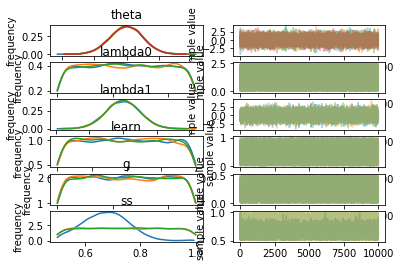

In [2]:
with open("model_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)


For the full summary use 'print(fit)'

Inference for Stan model: hotDINA_0169052b413d03a229c34988eca0dc2d.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

               mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
theta[1]      -0.11    0.01   0.97   -2.0  -0.78   -0.12   0.53    1.8   8713    1.0
theta[2]       0.74    0.39   1.29   -1.8  -0.26    0.91   1.72   2.91     11   1.15
theta[3]      -0.23    0.34    1.3  -2.34  -1.15   -0.48   0.59   2.58     14   1.16
theta[4]       0.23    0.01   1.06  -1.87  -0.49    0.24   0.97   2.23   5168    1.0
lambda0[1]     1.25  7.1e-3   0.72   0.06   0.62    1.24   1.87   2.43  10292    1.0
lambda0[2]     1.26  6.8e-3   0.74   0.05   0.61    1.27   1.91   2.45  11814    1.0
lambda0[3]     1.26  7.4e-3   0.72   0.07   0.65    1.26   1.89   2.44   9430    1.0
lambda0[4]     1.26  6.5e-3   0.72   0.07   0.65    1.27   1.87   2.43  12142    1.0
lambda0[5

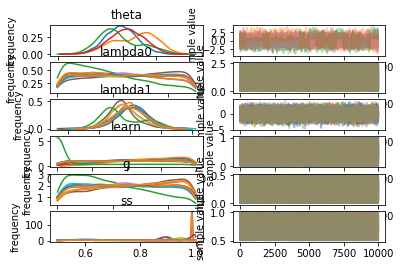

In [3]:
data_dict['fit']

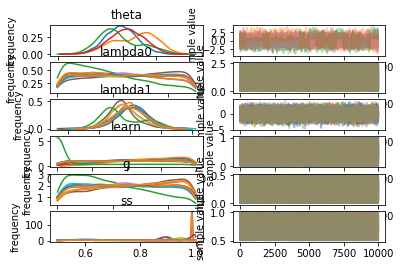

In [4]:
p = data_dict['fit'].plot()

In [5]:
import arviz

/home/jith/.local/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c49c9c7d0>,
      dtype=object)

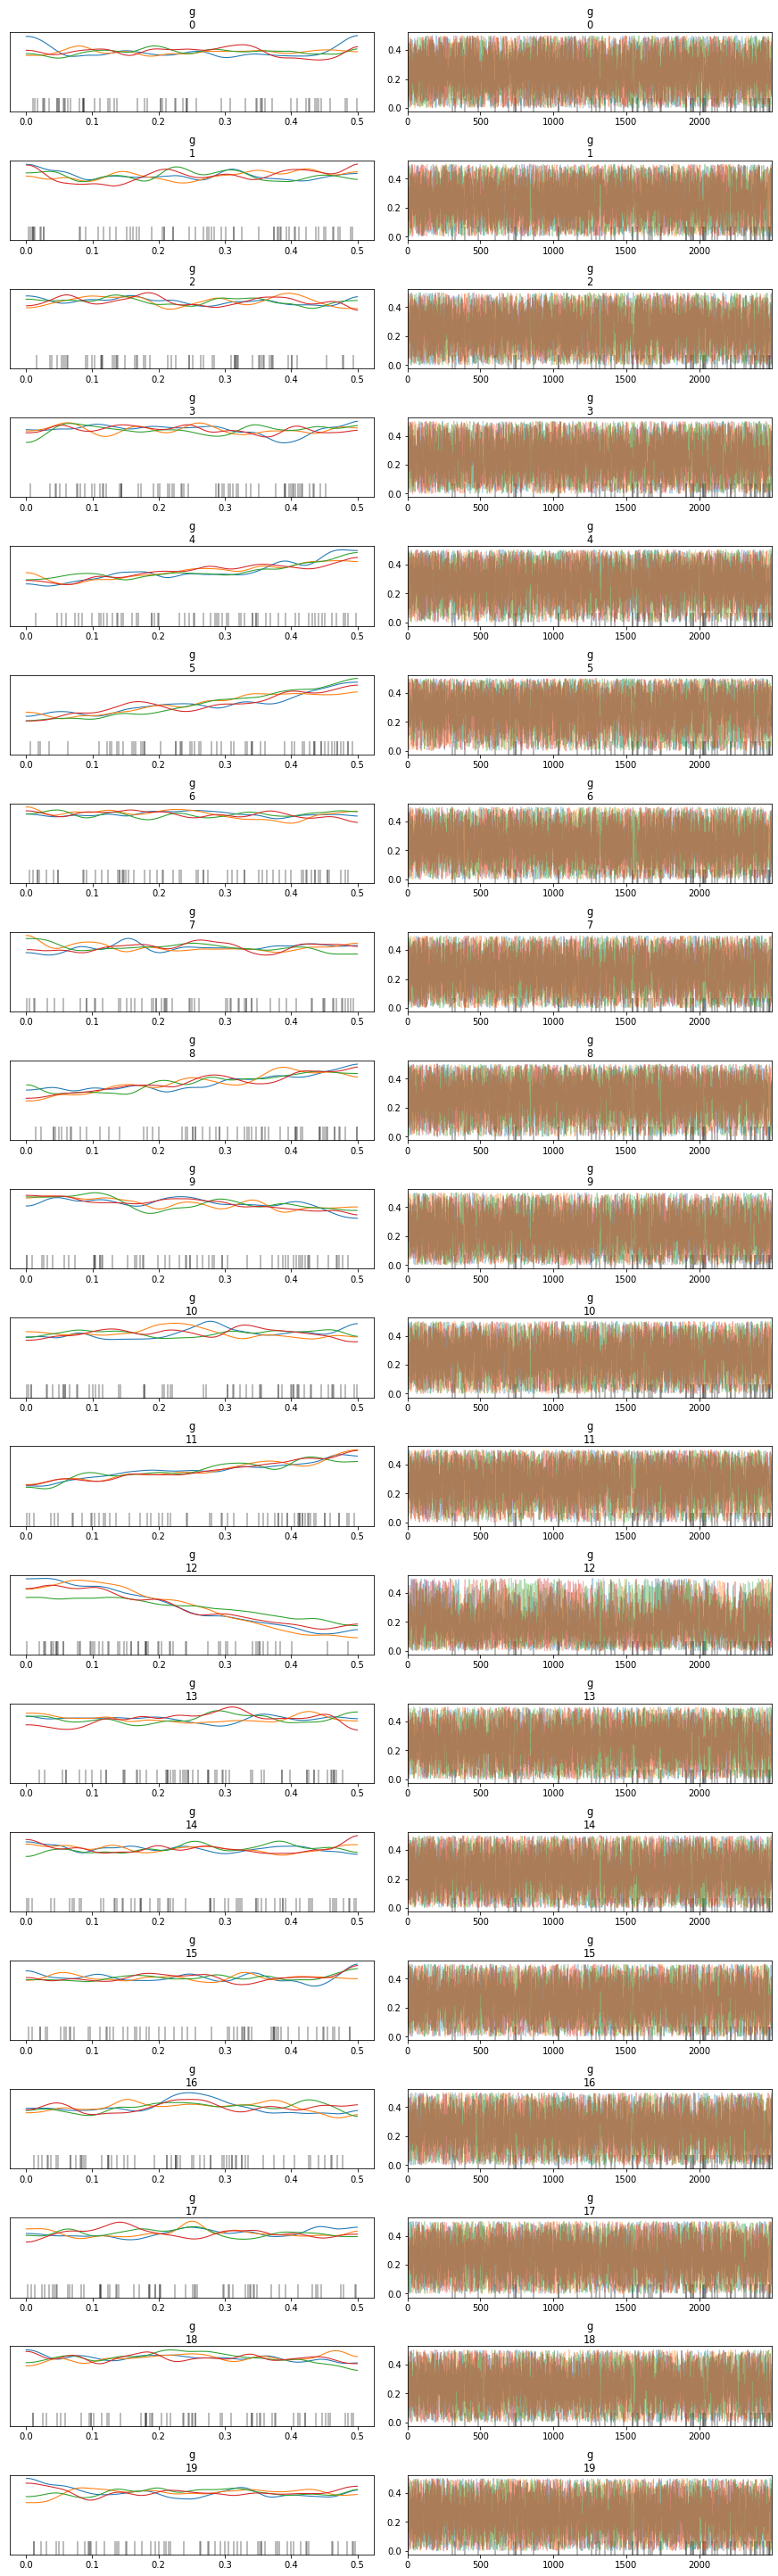

In [9]:
arviz.plot_trace(data_dict['fit'], ['g'])

In [7]:
data_dict['fit']


For the full summary use 'print(fit)'

Inference for Stan model: hotDINA_0169052b413d03a229c34988eca0dc2d.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

               mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
theta[1]      -0.11    0.01   0.97   -2.0  -0.78   -0.12   0.53    1.8   8713    1.0
theta[2]       0.74    0.39   1.29   -1.8  -0.26    0.91   1.72   2.91     11   1.15
theta[3]      -0.23    0.34    1.3  -2.34  -1.15   -0.48   0.59   2.58     14   1.16
theta[4]       0.23    0.01   1.06  -1.87  -0.49    0.24   0.97   2.23   5168    1.0
lambda0[1]     1.25  7.1e-3   0.72   0.06   0.62    1.24   1.87   2.43  10292    1.0
lambda0[2]     1.26  6.8e-3   0.74   0.05   0.61    1.27   1.91   2.45  11814    1.0
lambda0[3]     1.26  7.4e-3   0.72   0.07   0.65    1.26   1.89   2.44   9430    1.0
lambda0[4]     1.26  6.5e-3   0.72   0.07   0.65    1.27   1.87   2.43  12142    1.0
lambda0[5